In [1]:
import scipy
import datetime
import functools
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline 

tfd = tf.contrib.distributions
tfb = tf.contrib.bayesflow

Instructions for updating:
Use the retry module or similar alternatives.


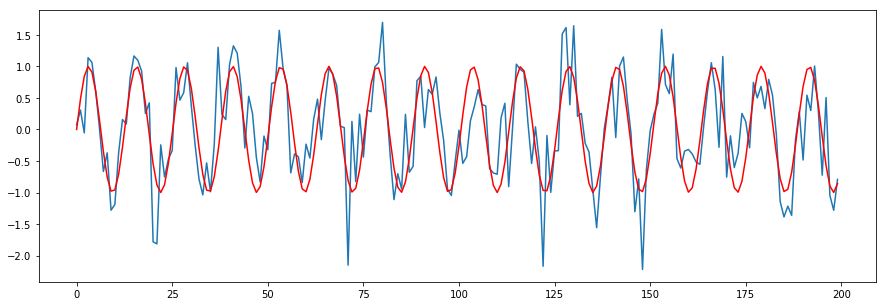

In [2]:
time = np.arange(0, 100, 0.5)
sigma = 0.5
y = np.sin(time)
y_tilde = y[None, :] + sigma * np.random.randn(10, len(time))

fig, ax = plt.subplots(1,1,figsize=(15, 5))
plt.plot(y_tilde[0])
plt.plot(y, 'r')
ts = y_tilde[0]

In [3]:
def doublewrap(function):
    """
    A decorator decorator, allowing to use the decorator to be used without
    parentheses if not arguments are provided. All arguments must be optional.
    """
    @functools.wraps(function)
    def decorator(*args, **kwargs):
        if len(args) == 1 and len(kwargs) == 0 and callable(args[0]):
            return function(args[0])
        else:
            return lambda wrapee: function(wrapee, *args, **kwargs)
    return decorator


@doublewrap
def define_scope(function, scope=None, *args, **kwargs):
    """
    A decorator for functions that define TensorFlow operations. The wrapped
    function will only be executed once. Subsequent calls to it will directly
    return the result so that operations are added to the graph only once.
    The operations added by the function live within a tf.variable_scope(). If
    this decorator is used with arguments, they will be forwarded to the
    variable scope. The scope name defaults to the name of the wrapped
    function.
    """
    attribute = '_cache_' + function.__name__
    name = scope or function.__name__
    @property
    @functools.wraps(function)
    def decorator(self):
        if not hasattr(self, attribute):
            with tf.variable_scope(name, *args, **kwargs):
                setattr(self, attribute, function(self))
        return getattr(self, attribute)
    return decorator

In [109]:
class LinearMarkovianCellWithState(tf.contrib.rnn.RNNCell):
    """
    """
    def __init__(self, event_size, state_size, reuse=None):
        super(LinearMarkovianCellWithState, self).__init__(_reuse=reuse)
        self._state_size = state_size
        self._event_size = event_size
        self._A = tf.get_variable('A', shape=(state_size, state_size), dtype=tf.float32)
        self._B = tf.get_variable('B', shape=(event_size, state_size), dtype=tf.float32)
        self._c = tf.get_variable('c', shape=(event_size,), dtype=tf.float32)
        self._D = tf.get_variable('D', shape=(state_size, event_size), dtype=tf.float32)
        self._e = tf.get_variable('e', shape=(event_size,), dtype=tf.float32)
        
    @property
    def state_size(self):
        return self._state_size

    @property
    def output_size(self):
        return self._event_size

    def call(self, inputs, state):
        state = tf.matmul(state, self._A)  + tf.matmul(inputs, self._B) + self._c
        mean = tf.matmul(state, self._D) + self._e
        return mean, state
    
class GaussianCell(tf.contrib.rnn.RNNCell):
    
    def __init__(self, cell, event_size, std, reuse=None):       
        super(GaussianCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._event_size = event_size
        self._std = std[None, None]

    @property
    def state_size(self):
        return self._cell.state_size

    @property
    def output_size(self):
        return (self._event_size, self._event_size)

    def call(self, inputs, state):
        mean, state = self._cell(inputs, state)
        n_samples = mean.shape[0]
        return (mean, tf.tile(self._std, (n_samples, 1))), state
    
class SamplingCell(tf.contrib.rnn.RNNCell):
    """
    RNN cell that produce a sequence in autoregressive mode by sampling at
    each step
    """

    def __init__(self, cell, output_size, n_samples=1, reuse=None):
        super(SamplingCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._output_size = output_size
        self._n_samples = n_samples

    @property
    def state_size(self):
        return (self._cell.state_size, self._output_size)

    @property
    def output_size(self):
        return (self._output_size, self._output_size)

    def call(self, _ , state_and_sample):
        (state, sample) = state_and_sample
        (mean, std), state = self._cell(sample, state)
        sample = tfd.Normal(mean, std).sample()
        return (mean, std), (state, sample)

In [110]:
class RobustARGenerator(object):
    """
    Model to test
    """
    def __init__(self, data, n_hidden=100, n_samples=200, seq_length=100, batch_size=1):
        self._data = data                                         # B x T x 1
        self._H = n_hidden                                        # H
        self._B = batch_size                                      # B
        self._S = n_samples                                       # S
        self._T = seq_length                                      # T
        self._cell = LinearMarkovianCellWithState(1, self._H)
        self._gen_std = tf.nn.softplus(tf.get_variable('generative_std', shape=(), 
                                       initializer=tf.constant_initializer(1)))
        
        self._trans_std = tf.nn.softplus(tf.get_variable('transitional_std', shape=(), 
                                         initializer=tf.constant_initializer(1)))
        
        self._optimiser = tf.train.AdamOptimizer(0.001)
        self.make_posterior
        self.compute_elbo
        self.E_step
        self.M_step
        
        self.make_forward_posterior
        self.make_forward_parameters
        self.compute_elbo_forward
        self.forward_E_step
        self.forward_M_step
    
    @define_scope
    def make_posterior(self):
        means = tf.Variable(initial_value=tf.zeros((self._T, 1)), name='post_means', dtype=tf.float32)
        self._post_std = tf.nn.softplus(tf.get_variable(shape=(), initializer=tf.constant_initializer(1), 
                                        name='post_stddev'))
        return tfd.MultivariateNormalDiag(means, scale_identity_multiplier=self._post_std)
    
    @define_scope
    def make_entropy_y(self):
        const = np.log(np.sqrt(2 * np.pi * np.e))
        return self._T * self._B * (tf.log(self._post_std) + const)
    
    @define_scope
    def make_kl_y(self):
        entropy = self.make_entropy_y
        const = np.log(np.sqrt(2 * np.pi)) 
        means = self.make_transitional
        means = tf.reshape(means, [self._S, self._B, self._T])
        self._code = tf.reshape(self._code, [self._S, self._B, self._T])

        exponent_trans = tf.square(self._code - means)/(2 * tf.square(self._trans_std))
        norm_trans = self._B * self._T * (tf.log(self._trans_std) + const)
        exp_trans = tf.reduce_sum(tf.reduce_mean(exponent_trans, 0))
    
        return - entropy + exp_trans + norm_trans
    
    @define_scope
    def make_transitional(self):
        code = tf.reshape(self._code, [-1, self._T, 1])
        inputs = tf.concat([tf.zeros((self._B * self._S, 1, 1)), code[:, :-1]], 1)
        means, _ = tf.nn.dynamic_rnn(self._cell, inputs=inputs, dtype=tf.float32)
        return means
    
    @define_scope
    def make_reconstruction(self):
        const = np.log(np.sqrt(2 * np.pi))
        exponent_gen = tf.square(self._code - self._data[None, ..., 0])
        exponent_gen = tf.reduce_sum(tf.reduce_mean(exponent_gen/(2 * tf.square(self._gen_std)), 0))
        norm_gen = self._B * self._T * (tf.log(self._gen_std) + const)
        return - exponent_gen - norm_gen
    
    @define_scope
    def compute_elbo(self):      
        posterior = self.make_posterior
        self._code = posterior.sample((self._B * self._S)) # (S * B) x T x 1

        entropy = self.make_entropy_y        
        kl = self.make_kl_y
        reconstruction = self.make_reconstruction     
        loss = reconstruction - kl
        
        return loss, kl, reconstruction, entropy
    
    @define_scope
    def compute_elbo_david(self):
        pass
    
#     @define_scope
#     def trans_std(self):
#         posterior = self.make_posterior
#         code = tf.transpose(posterior.sample((self._S * self._B)), [0, 2, 1])
#         means = self.make_transitional
#         return tf.sqrt(tf.reduce_mean(tf.square(code[..., 0] - means[..., 0])))
    
#     @define_scope
#     def gen_std(self):
#         posterior = self.make_posterior
#         exp1 = tf.reduce_mean(tf.square(posterior.mean() - self._data[..., 0]))
#         return tf.sqrt(tf.square(self._post_stddev) + exp1)

    @define_scope
    def E_step(self):
        post_var = [v for v in tf.trainable_variables() if v.name.startswith('make_posterior/')]
        return self._optimiser.minimize(-self.compute_elbo[0], var_list=post_var)
    
    @define_scope
    def M_step(self):
        non_post_var = [v for v in tf.trainable_variables() if not v.name.startswith('make_posterior/')]
        return self._optimiser.minimize(-self.compute_elbo[0], var_list=non_post_var)
    
    @define_scope
    def make_forward_posterior(self):
        y_mu = tf.get_variable(shape=(), name='forward_y_mean', initializer=tf.constant_initializer(0))
        y_sigma = tf.nn.softplus(tf.get_variable(shape=(), initializer=tf.constant_initializer(2), 
                                                 name='forward_y_std'))
        y_dist = tfd.Normal(y_mu, y_sigma)
        return y_dist

    @define_scope
    def make_forward_parameters(self):
        return tf.get_variable(shape=(50,), name='best_forward_sequence', initializer=tf.constant_initializer(0))
    
    @define_scope
    def compute_forward_message(self):
        h = tf.zeros((self._S, self._H))                                       # S x H
        code = self._code                                                      # S x B x T
        code = code[:, 0, :]                                                   # S x T
        for t in range(self._T):
            _, h = self._cell(code[:, t, None], h)
            h = tf.tile(tf.reduce_mean(h, 0, keepdims=True), [self._S, 1])
        
        dist_y = tfd.Normal(self.make_posterior.mean()[-1, 0], self._post_std)
        return dist_y, h
    
    @define_scope
    def make_rnn_forward(self):
        _, hT = self.compute_forward_message
        hT = tf.tile(tf.reduce_mean(hT, 0, keepdims=True), [self._S, 1])
        fake_inputs = tf.zeros((self._S, 50, 1))
        post_samples = self.make_forward_posterior.sample((self._S))
        (means, stddevs), _ = tf.nn.dynamic_rnn(self._sampling_cell, inputs=fake_inputs, 
                                                initial_state=(hT, post_samples[..., None]))
        return means, stddevs
    
    @define_scope
    def compute_elbo_forward(self):
        self._gauss_cell = GaussianCell(self._cell, 1, self._trans_std)
        self._sampling_cell = SamplingCell(self._gauss_cell, 1, self._S)
        
        post = self.make_forward_posterior
        post_samples = post.sample((self._S))
        entropy = tf.log(tf.square(post.scale))
        
        dist_y, _ = self.compute_forward_message
        means, stddevs = self.make_rnn_forward
        
        pred = self.make_forward_parameters
        reconstruction_exp = tf.square(pred[None, :] - means[..., 0])/tf.square(stddevs[..., 0])
        reconstruction_norm = tf.reduce_sum(tf.reduce_mean(tf.log(tf.square(stddevs)), 0))
        reconstruction = - tf.reduce_mean(tf.reduce_sum(reconstruction_exp, -1)) - reconstruction_norm
        
        cross = tf.square(dist_y.mean() - post_samples)/tf.square(dist_y.scale)
        kl = - entropy + tf.reduce_mean(cross) + tf.log(tf.square(dist_y.scale))
        
        return reconstruction - kl, kl, reconstruction, entropy
    
    @define_scope
    def forward_E_step(self):
        post_var = [v for v in tf.trainable_variables() if 'make_forward_posterior' in v.name]
        return self._optimiser.minimize(-self.compute_elbo_forward[0], var_list=post_var)
    
    @define_scope
    def forward_M_step(self):
        post_var = [v for v in tf.trainable_variables() if 'make_forward_parameters' in v.name]
        return self._optimiser.minimize(-self.compute_elbo_forward[0], var_list=post_var)

In [111]:
tf.reset_default_graph()

seq_length = 70; n_samples = 100; batch_size = 10;
data = np.tile(y_tilde[:batch_size, :seq_length], (n_samples, 1))
x_ = tf.placeholder(tf.float32, [batch_size, seq_length, 1])

gen_model = RobustARGenerator(x_, n_hidden=2, n_samples=n_samples, seq_length=seq_length, batch_size=batch_size)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

elbos = []; kls = []; llks = []; test_elbos = []; preds = []; preds_greedy = []; entropies = [];
means = []; stds = []; gen_stddevs = []; post_stddevs = []; post_samples = []; post_means = []

for i in range(25001):
    batch = data[:batch_size]
    
    elbo, kl, llk, entropy = sess.run(gen_model.compute_elbo, {x_: batch[..., None]})
    elbos.append(elbo); kls.append(kl); llks.append(llk)
    post_means.append(sess.run(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'make_posterior/post_means:0'))[0])
    post_stddevs.append(sess.run(gen_model._post_std))
    m = sess.run(gen_model.make_transitional, {x_: batch[..., None]})
    s = sess.run(gen_model._trans_std, {x_: batch[..., None]})
    means.append(m); stds.append(s); gen_stddevs.append(sess.run(gen_model._gen_std, {x_: batch[..., None]}))
    latents = sess.run(gen_model._code, {x_: batch[..., None]})
    post_samples.append(latents)
    
    if i % 1000 == 0:
        print('Iteration:', i, 'ELBO:', elbo, 'KL:', kl, 'Reconstruction:', llk, 'Entropy:', entropy)
    
    sess.run(gen_model.E_step, {x_: batch[..., None]})
    sess.run(gen_model.M_step, {x_: batch[..., None]})

Iteration: 0 ELBO: -6174.216 KL: 4837.9595 Reconstruction: -1336.2561 Entropy: 1184.0167
Iteration: 1000 ELBO: -1215.2646 KL: 117.20392 Reconstruction: -1098.0608 Entropy: 1011.19714
Iteration: 2000 ELBO: -1131.4623 KL: 110.732544 Reconstruction: -1020.72974 Entropy: 912.7101
Iteration: 3000 ELBO: -1035.9548 KL: 110.7829 Reconstruction: -925.17194 Entropy: 768.1783
Iteration: 4000 ELBO: -958.6052 KL: 135.17935 Reconstruction: -823.42584 Entropy: 574.9241
Iteration: 5000 ELBO: -914.6995 KL: 173.70018 Reconstruction: -740.9993 Entropy: 390.81976
Iteration: 6000 ELBO: -907.5243 KL: 192.11682 Reconstruction: -715.4075 Entropy: 298.97354
Iteration: 7000 ELBO: -905.8656 KL: 184.83047 Reconstruction: -721.03516 Entropy: 282.06268
Iteration: 8000 ELBO: -909.751 KL: 181.80429 Reconstruction: -727.94666 Entropy: 281.21405
Iteration: 9000 ELBO: -908.83954 KL: 178.45508 Reconstruction: -730.38446 Entropy: 281.23022
Iteration: 10000 ELBO: -907.7014 KL: 174.85347 Reconstruction: -732.84796 Entropy: 

In [112]:
tf.train.Saver().save(sess, '/Users/robertofiermonte/Repository/model_{}.ckpt'.format(batch_size))
for i in range(15001):   
    elbo_forward = sess.run(gen_model.compute_elbo_forward, {x_: batch[..., None]})
    sess.run(gen_model.forward_E_step, {x_: batch[..., None]})
    sess.run(gen_model.forward_M_step, {x_: batch[..., None]})
    
    if i % 1000 == 0:
        print('Iteration:', i, 'ELBO Forward:', elbo_forward)

Iteration: 0 ELBO Forward: (-21710.133, 3658.9788, -18051.154, 1.5093575)
Iteration: 1000 ELBO Forward: (-457.66028, 791.0741, 333.41382, -0.13916218)
Iteration: 2000 ELBO Forward: (13.706085, 320.5578, 334.2639, -0.99907035)
Iteration: 3000 ELBO Forward: (178.46098, 155.90767, 334.36865, -1.7008767)
Iteration: 4000 ELBO Forward: (262.15714, 72.250145, 334.4073, -2.3273382)
Iteration: 5000 ELBO Forward: (282.1627, 52.276997, 334.4397, -2.9043825)
Iteration: 6000 ELBO Forward: (310.4557, 23.986767, 334.44244, -3.4476378)
Iteration: 7000 ELBO Forward: (318.8545, 15.596812, 334.4513, -3.9642358)
Iteration: 8000 ELBO Forward: (325.83432, 8.626891, 334.4612, -4.460462)
Iteration: 9000 ELBO Forward: (330.5775, 3.8824492, 334.45996, -4.9325867)
Iteration: 10000 ELBO Forward: (332.87057, 1.5954885, 334.46606, -5.3733106)
Iteration: 11000 ELBO Forward: (332.43805, 2.0260038, 334.46405, -5.7752557)
Iteration: 12000 ELBO Forward: (333.40262, 1.061862, 334.46448, -6.125166)
Iteration: 13000 ELBO F

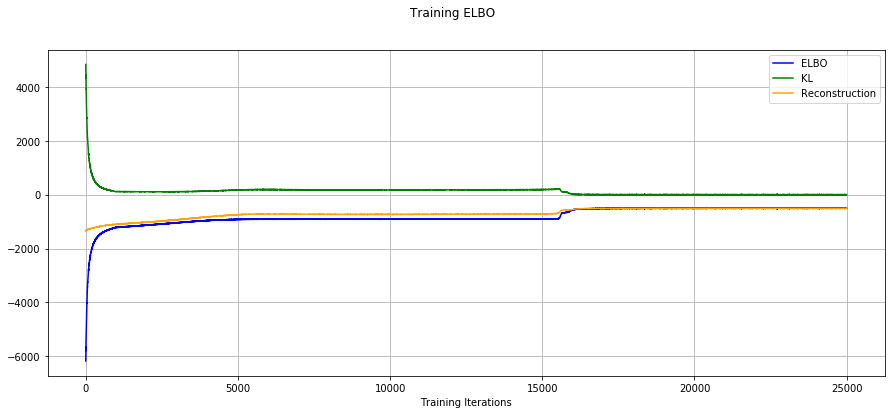

In [122]:
# New plot
fig, ax = plt.subplots(1, 1, figsize=(15,6))
plt.plot(elbos, 'b', label='ELBO')
plt.plot(kls, 'g', label='KL')
plt.plot(llks, 'orange', label='Reconstruction')
plt.plot(entropy)
plt.suptitle('Training ELBO')
ax.set_xlabel('Training Iterations')
plt.grid("on")
plt.legend();

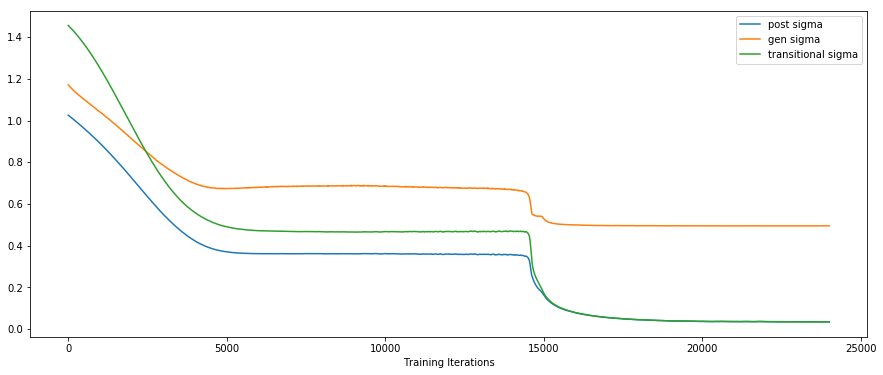

In [125]:
# p is RNN + linear proj., sigma_c is unknown, q is an RNN on the observed values + linear proj. (10 sample)
fig, ax = plt.subplots(1, 1, figsize=(15,6))
plt.plot(np.squeeze(np.array(post_stddevs))[1000:], label='post sigma')
plt.plot(gen_stddevs[1000:], label='gen sigma')
plt.plot([np.mean(s) for s in stds][1000:], label='transitional sigma')
ax.set_xlabel('Training Iterations')
plt.legend();

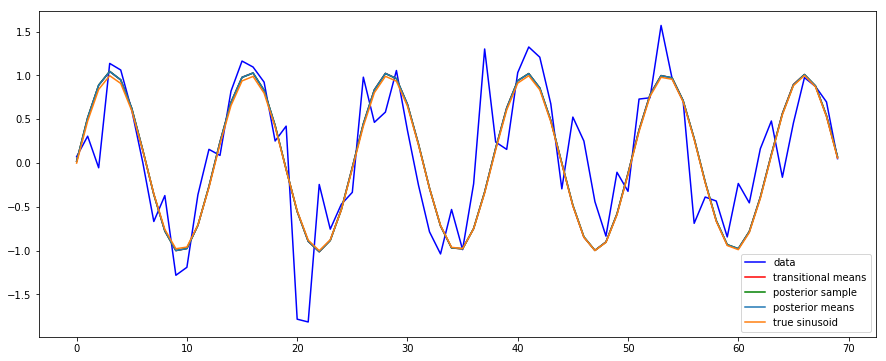

In [121]:
# Plot with GRU
plt.subplots(1,1,figsize=(15,6))
plt.plot(ts[:70], 'b', label='noisy data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
# plt.plot(stds[-1], 'k', label='transitional stddev')
plt.plot(np.mean(np.reshape(latents, [-1, 70]), 0), 'g', label='posterior sample')
plt.plot(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), label='posterior means')
plt.plot(y[:70], label='true sinusoid')
plt.legend();

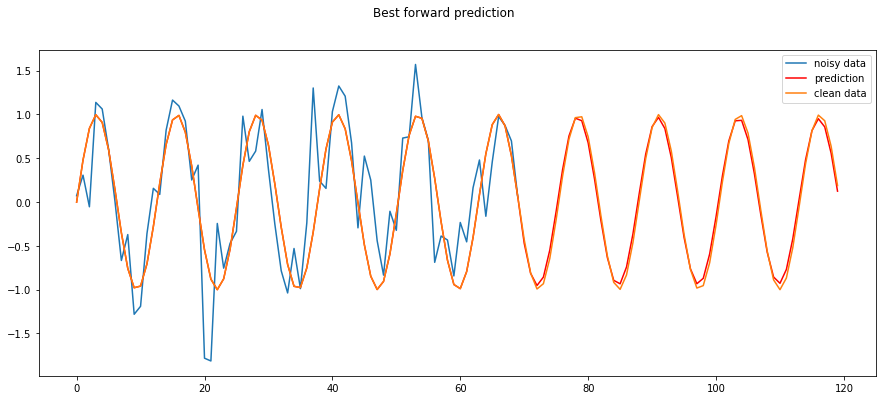

In [113]:
# Best forward pred at 10000 iters
code = sess.run(gen_model.make_forward_parameters, {x_: batch[..., None]})
fig, axs = plt.subplots(1,1,figsize=(15, 6))
plt.plot(y_tilde[0, :seq_length], label='noisy data')
plt.plot(np.concatenate([y[:seq_length], code], 0), 'r', label='prediction')
plt.plot(y[:seq_length+50], label='clean data')
plt.legend()
plt.suptitle("Best forward prediction");